In [141]:
from datetime import datetime
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import time
from io import StringIO
import random

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas_profiling
import copy
import numpy as np
import math

sns.set()

### References ###
* [歷年股利股息](https://stock.wespai.com/p/5625#)
* [內部投資報酬率概念 Internal Rate of Return](http://greenhornfinancefootnote.blogspot.com/2007/07/internal-rate-of-return.html)
* [股息折現試算表](https://td263736.pixnet.net/blog/post/448062347-%E8%82%A1%E6%81%AF%E6%8A%98%E7%8F%BE%E8%A9%A6%E7%AE%97%E8%A1%A8)
* [CMoney: 現金股利折現法](http://www.cmoney.tw/learn/course/0520/topic/1017)
* [Medium-[書摘]財報狗教你挖好股穩賺20%](https://medium.com/%E8%AA%A0%E8%AD%98%E4%B8%8D%E8%B6%B3/%E6%9B%B8%E6%91%98-%E8%B2%A1%E5%A0%B1%E7%8B%97%E6%95%99%E4%BD%A0%E6%8C%96%E5%A5%BD%E8%82%A1%E7%A9%A9%E8%B3%BA20-d5e2ac2fd3fb)

In [160]:
url = 'https://stock.wespai.com/p/5625'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r = requests.get(url, headers=headers)
r.encoding = 'utf8'

dfs = pd.read_html(StringIO(r.text), encoding='utf-8')
df = pd.concat([df for df in dfs if df.shape[1] <= 21 and df.shape[1] > 9])
df.drop(list(df.filter(regex = '配股')), axis = 1, inplace = True)
# df.drop('公司', axis = 1, inplace = True)

### 把股價欄存到另一個dataframe
df_price = df[['股價']]
df.drop('股價', axis = 1, inplace = True)
    
df = df.T
df_price = df_price.T
header = df.iloc[0]
df = df[2:]
df.rename(columns = header, inplace=True)
df_price.rename(columns = header, inplace=True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], 'coerce')
    
df.columns = df.columns.astype(str)
df_price.columns = df_price.columns.astype(str)
df = df.T
for (col,y) in zip(df.columns, range(len(df.columns))):
    df.rename(columns={col:'%d' %(2019-y)}, inplace=True)

df = df.T
df.index = pd.to_datetime(df.index, format='%Y-%m-%d').year
df = df.sort_index()
df

,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
2011,1.80,1.8,0.200000,0.50,0.17,0.35,0.2,0.6,0.576831,1.200000,...,0.200000,0.950000,0.000000,0.87,1.600,0.3,2.000000,0.100000,0.0,0.00
2012,2.00,1.9,0.300000,1.00,0.00,0.28,0.1,0.6,0.500000,1.187166,...,0.500000,1.000000,0.000000,0.80,1.270,2.0,1.737815,0.200000,0.4,0.40
2013,1.90,2.3,0.200000,0.60,0.00,0.35,0.1,0.6,0.500000,1.188808,...,0.200000,1.800000,0.000000,0.55,1.186,2.5,0.000000,0.000000,1.0,0.80
2014,1.90,1.7,0.000000,0.75,0.00,0.38,0.1,0.6,0.300000,1.200000,...,0.200000,2.912684,2.084463,0.65,1.060,2.0,0.300000,0.248595,1.0,1.10
2015,2.30,1.8,1.000000,0.90,0.45,1.20,0.2,0.6,1.000000,1.000000,...,0.383959,4.399620,0.000000,0.60,1.120,5.0,0.000000,0.800000,0.8,0.70
2016,2.49,2.2,0.300299,1.00,0.60,0.20,0.2,0.0,1.000000,1.000000,...,0.390693,3.996817,0.000000,0.30,0.440,5.4,0.000000,0.100000,0.8,0.20
2017,1.33,1.1,0.100000,1.00,0.85,0.20,0.2,0.0,1.000000,0.700000,...,0.300000,0.000000,1.000000,0.00,0.343,5.5,0.000000,0.400000,0.5,0.00
2018,1.45,0.9,0.200000,1.20,0.60,0.10,0.1,0.0,1.000000,1.500000,...,0.300000,0.000000,0.500000,0.00,0.000,5.8,0.000000,0.300000,0.4,0.60
2019,1.50,1.2,0.500000,1.10,0.00,0.10,0.1,0.0,1.300000,2.000000,...,0.300000,2.000000,0.600000,0.00,0.000,5.3,0.000000,0.300000,0.0,0.65


股息成長率(%) = 4.9348107833327655


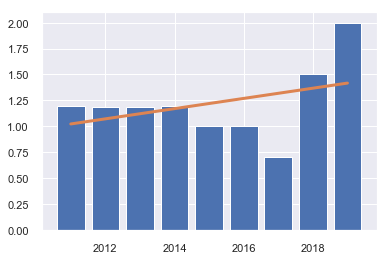

In [123]:
company = 1210
plt.bar(df[str(company)].index,df[str(company)])
coef = np.polyfit(df[str(company)].index,df[str(company)],1)
poly1d_fn = np.poly1d(coef)
plt.plot(df[str(company)].index,poly1d_fn(df[str(company)].index),color='C1',lw=3)
print ('股息成長率(%) =',coef[0]*100.)

In [124]:
### Ignore 2812, 2820, 2838, 2850, 2851, 2855, 2867, 2884, 2886, 2887, 2889, 2890, 5880, 6005
try:
    df_fstatement = pd.read_csv('./Financial_statement/%d.csv' %(company),index_col=0)  

    df_fstatement.index = pd.to_datetime(df_fstatement.index, format='%Y-%m-%d').year

    ### Bug fix: pct_change() does not properly deal with negative values 
    df_fstatement['淨利成長率'] = (df_fstatement['繼續營業單位稅前淨利（淨損）'] - df_fstatement['繼續營業單位稅前淨利（淨損）'].shift())/abs(df_fstatement['繼續營業單位稅前淨利（淨損）'].shift()) * 100.
    df_fstatement['營收成長率'] = (df_fstatement['營業收入合計'] - df_fstatement['營業收入合計'].shift())/abs(df_fstatement['營業收入合計'].shift()) * 100.

    col_names = ['營業收入合計','營業毛利（毛損）','營業利益（損失）',
                 '繼續營業單位稅前淨利（淨損）','營業費用合計','本期淨利（淨損）',
                 '基本每股盈餘合計','本期現金及約當現金增加（減少）數','股東權益總額',
                 '資產總額','營業毛利率(%)','營業利益率(%)','純益率(%)','股東權益率(%)',
                 '總資產報酬率(%)','營收成長率','淨利成長率']

    ### 財務報表名詞中翻英: http://twstockcurves.blogspot.com/2014/08/blog-post.html
    col_names = ['Revenue','Gross Revenue','Operating Income',
                 'Income from Continuing Operation (before tax)','Operating Expenses','Net Income',
                 'Earnings Per Share','Net Increase (decrease) In Cash and Cash Equivalents','Total Equity',
                 'Total Assets','Profit Margin (%)','Operating Profit Margin (%)','Net Profit Margin (%)','Equity Ratio (%)',
                 'Return On Total Assets (%)','Revenue Growth Rate (%)','Net Profit Growth Rate (%)']


    for iname in range(len(col_names)):
        df_fstatement.rename(columns={df_fstatement.columns[iname]: col_names[iname]}, inplace=True)

    print ('Company %d \nNo error has occured, print dataframe in the next block' %(company))
    
except Exception as e:
    print('Company %d \nErrors have occured, please check if anything is wrong' %(company))


Company 1210 
No error has occured, print dataframe in the next block


In [125]:
(df_fstatement.style.background_gradient(cmap='Blues')
                        .bar(subset=['Revenue Growth Rate (%)'],color=['indianred','limegreen'], align='mid')
                        .bar(subset=['Net Profit Growth Rate (%)'],color=['indianred','limegreen'], align='mid'))

/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,Revenue,Gross Revenue,Operating Income,Income from Continuing Operation (before tax),Operating Expenses,Net Income,Earnings Per Share,Net Increase (decrease) In Cash and Cash Equivalents,Total Equity,Total Assets,Profit Margin (%),Operating Profit Margin (%),Net Profit Margin (%),Equity Ratio (%),Return On Total Assets (%),Revenue Growth Rate (%),Net Profit Growth Rate (%)
2010,6.78579e+07,6.67715e+06,1.90671e+06,1.97215e+06,4.77043e+06,1.55224e+06,2.63,-259973,1.43896e+07,2.56083e+07,9.8399,2.80986,2.90629,13.7053,7.70119,nan,nan
2011,7.35045e+07,6.53803e+06,1.45458e+06,1.80557e+06,5.08345e+06,1.54307e+06,2.36,228345,1.47836e+07,2.81855e+07,8.89474,1.9789,2.45641,12.2133,6.40602,8.32117,-8.44653
2012,8.40627e+07,7.49756e+06,1.8221e+06,2.07942e+06,5.67546e+06,1.7742e+06,2.22,1.08991e+06,1.65972e+07,3.29339e+07,8.91902,2.16755,2.47365,12.5287,6.31392,14.3641,15.1669
2013,8.75226e+07,6.94748e+06,1.13251e+06,1.36125e+06,5.81497e+06,1.10728e+06,1.43,-639,1.69261e+07,3.48561e+07,7.93793,1.29397,1.55532,8.04236,3.90535,4.11587,-34.5367
2014,9.0478e+07,7.65525e+06,840305,2.59334e+06,6.81494e+06,2.25664e+06,3.42,352562,1.87883e+07,3.8458e+07,8.46089,0.928739,2.86626,13.803,6.7433,3.37675,90.511
2015,9.17409e+07,7.99796e+06,1.14867e+06,1.49179e+06,6.84929e+06,999577,1.7,-406872,1.99444e+07,4.13951e+07,8.71798,1.25208,1.62609,7.47976,3.60379,1.39581,-42.476
2016,7.82522e+07,8.40412e+06,1.54166e+06,968699,6.86246e+06,486215,0.87,579583,1.92486e+07,4.00275e+07,10.7398,1.97012,1.23792,5.03257,2.42008,-14.7031,-35.0648
2017,7.57957e+07,9.92767e+06,2.7437e+06,3.14068e+06,7.18397e+06,2.56126e+06,3.01,-1.48546e+06,2.0183e+07,3.78643e+07,13.0979,3.61987,4.14362,15.561,8.29457,-3.13922,224.217
2018,7.5931e+07,1.02327e+07,3.01315e+06,3.33982e+06,7.21959e+06,2.65261e+06,3.28,741542,2.17229e+07,4.07479e+07,13.4764,3.96827,4.3985,15.3746,8.19631,0.178578,6.34066
2019,7.24429e+07,1.00881e+07,2.27262e+06,3.03119e+06,7.81547e+06,2.41361e+06,2.75,-680861,2.22226e+07,4.25263e+07,13.9256,3.13712,4.18425,13.6401,7.12781,-4.59375,-9.24088


EPS成長率(%) = 4.890909090908393


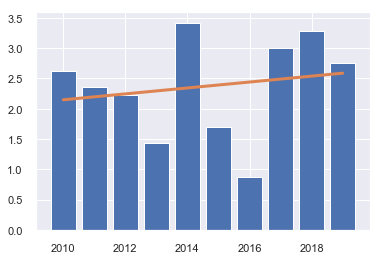

In [140]:
plt.bar(df_fstatement['Earnings Per Share'].index,df_fstatement['Earnings Per Share'])
coef_2 = np.polyfit(df_fstatement['Earnings Per Share'].index,df_fstatement['Earnings Per Share'],1)
poly1d_fn_2 = np.poly1d(coef_2)
plt.plot(df_fstatement['Earnings Per Share'].index,poly1d_fn_2(df_fstatement['Earnings Per Share'].index),color='C1',lw=3)
print ('EPS成長率(%) =',coef_2[0]*100.)

In [134]:
with open('Dividend_yield-200809to201911.pickle', 'rb') as file:
    data_dict = pickle.load(file)

data_PER = copy.deepcopy(data_dict)


for k in data_dict.keys():
    data_PER[k].rename(columns={'證券代號': 'Stock_symbol', '證券名稱': 'Stock_name', '殖利率(%)': 'Dividend_yield',
                  '股利年度': 'Divident_year', '本益比': 'PER', '股價淨值比': 'PBR', '財報年/季': 'Report_year_quarter'},inplace=True)
    data_PER[k].index = data_PER[k]['Stock_symbol']
    
    
df_PER = pd.DataFrame({k:df_PER['PER'] for k, df_PER in data_PER.items()}).transpose()
df_PER.index = pd.to_datetime(df_PER.index)
df_PER = df_PER.sort_index()

df_PER.head()


,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9939,9940,9941,9942,9943,9944,9945,9946,9955,9958
2008-09-01,12.90,10.17,14.46,21.49,17.28,17.96,19.25,17.94,225.00,11.76,...,11.55,14.43,9.62,8.06,9.29,1.69,29.76,NaN,15.94,8.85
2008-09-09,10.88,9.52,12.48,18.62,17.61,16.36,15.66,16.82,176.25,11.26,...,11.36,14.04,9.47,7.68,9.05,1.57,23.72,NaN,14.46,11.33
2008-09-17,8.25,7.78,10.43,17.82,15.79,14.68,14.38,14.49,154.38,10.51,...,10.61,10.35,9.09,7.19,8.84,1.44,19.88,NaN,12.24,11.11
2008-09-25,8.81,8.43,10.29,17.98,17.34,15.57,15.21,16.68,149.38,11.16,...,11.34,10.07,9.13,7.32,8.55,1.46,22.01,NaN,13.70,11.07
2008-10-01,7.80,7.98,9.24,17.18,16.03,14.87,14.75,16.87,145.00,10.41,...,10.97,9.63,8.94,7.14,7.96,1.38,21.22,NaN,13.11,10.44


In [137]:
print ('Min. PER =',df_PER[str(company)].min(),'\nMax. PER =',df_PER[str(company)].max())

Min. PER = 6.56 
Max. PER = 26.21


In [169]:
### EPS projection
proj_year = 10
EPS_proj = []
Dividend_proj = []
cons_price_proj = []
optim_price_proj = []
list_lowest_NPV = []
list_highest_NPV = []
list_lowest_NPV.append(-1.*df_price[str(company)].values[0])
list_highest_NPV.append(-1.*df_price[str(company)].values[0])
list_lowest_buy = []
list_highest_buy = []

print ('Current EPS = %.2f, Dividend = %.2f' %(df_fstatement['Earnings Per Share'].iloc[-1:].values[0], 
                                                df[str(company)].iloc[-1:].values[0]))
for y in range(1,proj_year+1,1):
    print ('Year %d:' %(y) + ' EPS = %.2f' %(df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y)), 
           'Dividend = %.2f' %(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y)))
    EPS_proj.append(df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]), y))
    Dividend_proj.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y))
    cons_price_proj.append(df_PER[str(company)].min()
                           *df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]), y))
    optim_price_proj.append(df_PER[str(company)].max()
                           *df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]), y))
    if y<proj_year:
        list_lowest_NPV.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y))
        list_highest_NPV.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y))
        list_lowest_buy.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y))
        list_highest_buy.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y))
    else:
        list_lowest_NPV.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y)
                               +df_PER[str(company)].min()*df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]), y))
        list_highest_NPV.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y)
                               +df_PER[str(company)].max()*df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]), y))
        list_lowest_buy.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y)
                               +df_PER[str(company)].min()*df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]), y))
        list_highest_buy.append(df[str(company)].iloc[-1:].values[0]*math.pow((1+coef_2[0]),y)
                               +df_PER[str(company)].max()*df_fstatement['Earnings Per Share'].iloc[-1:].values[0]*math.pow((1+coef_2[0]), y))
    

Current EPS = 2.75, Dividend = 2.00
Year 1: EPS = 2.88 Dividend = 2.10
Year 2: EPS = 3.03 Dividend = 2.20
Year 3: EPS = 3.17 Dividend = 2.31
Year 4: EPS = 3.33 Dividend = 2.42
Year 5: EPS = 3.49 Dividend = 2.54
Year 6: EPS = 3.66 Dividend = 2.66
Year 7: EPS = 3.84 Dividend = 2.79
Year 8: EPS = 4.03 Dividend = 2.93
Year 9: EPS = 4.23 Dividend = 3.07
Year 10: EPS = 4.43 Dividend = 3.22


In [168]:
print ('Min. IRR =', np.irr(list_lowest_NPV)*100, 
       '\nMax. IRR =',np.irr(list_highest_NPV) * 100)


Min. IRR = 2.932082124159985 
Max. IRR = 14.108975272753055


In [171]:
rate = 0.1
print ('Conservative value of stock price to buy =', np.npv(rate,list_lowest_buy) , 
       '\nOptimistic value of stock price to buy =', np.npv(rate,list_highest_buy))


Conservative value of stock price to buy = 29.428203565304166 
Optimistic value of stock price to buy = 66.37183447833347


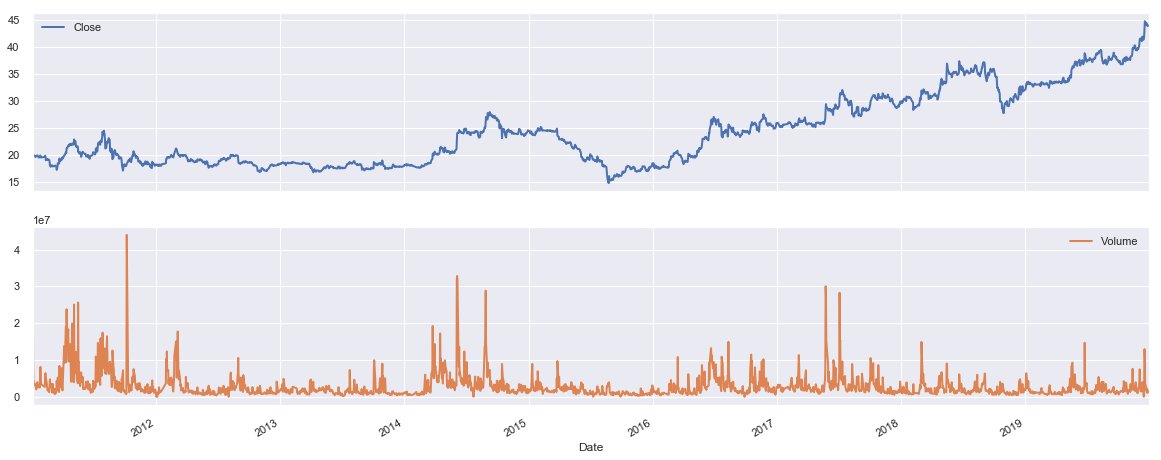

In [176]:
start = datetime(2011, 1, 1)
end = datetime(2017, 1, 10)

# TSM: 台積電
# 2317.TW: 鴻海
df_stockprice = web.DataReader('%d.TW' %(company), 'yahoo', start) 
df_stockprice[['Close','Volume']].plot(subplots = True, figsize = (20, 8), lw=2.)
plt.legend(loc='best')

In [186]:
import plotly.express as px
fig = px.line(df_stockprice, x=df_stockprice.index, y='Close')
fig.update_layout(
    title='Company symbol: %d' %(company),
    xaxis_title="Date",
    yaxis_title="Stock price",
    font=dict(
        size=18
    )
)
fig.show()